In [1]:
# Problem Statement:
# Pick a double integrator. Implement a PD controller for it.
# Use imitation learning (Dagger) to learn the PD controller.
# Use RL to improve on the imitation learning when there are disturbances.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'serif' : 'Computer Modern Roman',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.figsize'] = [2*3.54, 3.54]

from systems import DoubleIntegrator, DoubleIntegratorWithPerturbations

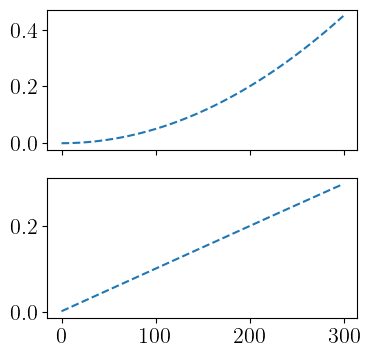

In [3]:
dt = 0.01
N = 300

# Systems
system = DoubleIntegrator(dt)
system_perturbed = DoubleIntegratorWithPerturbations(dt)

system.state = np.zeros(2)
system_perturbed.state = np.zeros(2)
state_list = []
state_perturb_list = []

for i in range(N):
    action = 0.1
    result = system.step(action)
    result_perturb = system_perturbed.step(action)
    state_list.append(system.state)
    state_perturb_list.append(system_perturbed.state)
    
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
state_list = np.array(state_list)
state_perturb_list = np.array(state_perturb_list)
# ax[0].plot(state_list[:, 0], '-', label='x')
ax[0].plot(state_perturb_list[:, 0], '--', label='x with perturbations')
# ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
ax[1].plot(state_perturb_list[:, 1], '--', label='\dot{x} with perturbations')


In [4]:
# Expert Policies
class ExpertPolicyIntegral:
    def __init__(self, dt):
        self.integral_term = 0
        self.dt = dt
        self.K = np.array([40.0 , 30.0]).reshape(1, 2)
        self.K_I = 10.0
        
    def __call__(self, state, state_des):
        self.integral_term += - self.K_I * (state[0] - state_des[0]) * self.dt
        # TODO antiwindup 
        u = (-self.K @ (state - state_des))[0]  + self.integral_term
        return u
    
class ExpertPolicyPD:
    def __init__(self, dt):
        self.dt = dt
        self.K = np.array([40.0 , 30.0]).reshape(1, 2)
        
    def __call__(self, state, state_des):
        u = (-self.K @ (state - state_des))[0]
        return u

class ExpertPolicyNonlinearPD:
    def __init__(self, dt):
        self.dt = dt
        self.K = np.array([40.0 , 30.0]).reshape(1, 2)
        
    def __call__(self, state, state_des):
        u = (-self.K @ (state - state_des))[0] + (10*np.sin(state[0]/10))**2
        return u
        
expert_policy = ExpertPolicyPD(dt)
expert_policy_nonlinear = ExpertPolicyNonlinearPD(dt)

# Test the expert controller

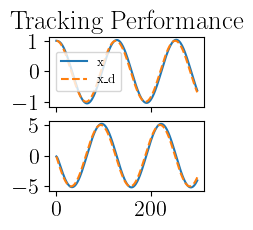

In [5]:
state_list = []

def get_N_pt_traj(N):
    des_traj_pos = lambda t: np.cos(t*0.05)
    pos_des = [des_traj_pos(i) for i in range(N)]
    des_traj_vel = np.zeros(N)

    for i in range(N - 1):
        des_traj_vel[i] = (pos_des[i+1] - pos_des[i])/dt
    return pos_des, des_traj_vel

des_traj_pos, des_traj_vel = get_N_pt_traj(N)

des_traj_list = []
x0 = np.array([des_traj_pos[0], des_traj_vel[0]])
system_perturbed.state = x0.copy()

for i in range(N-1):
    state_des = np.array([ des_traj_pos[i], des_traj_vel[i] ])
    action = expert_policy(system_perturbed.state, state_des)
    result = system_perturbed.step(action.squeeze())
    next_state = result[0]
    state_list.append(system_perturbed.state)
    des_traj_list.append(state_des)
    
state_list = np.array(state_list)
des_traj_list = np.array(des_traj_list)

fig, ax = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
ax[0].set_title('Tracking Performance')
ax[0].plot(state_list[:, 0], '-', label='x')
ax[0].plot(des_traj_list[:, 0], '--', label='x_d')
ax[0].legend(fontsize='xx-small')

ax[1].plot(state_list[:, 1], '-', label='\dot{x}')
ax[1].plot(des_traj_list[:, 1], '--', label='\dot{x}_d')


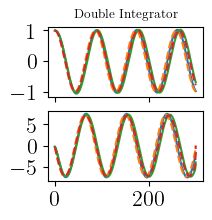

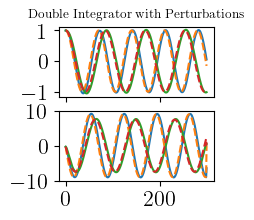

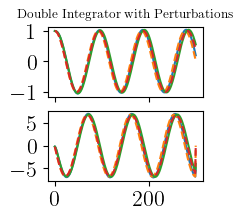

In [6]:
# Multiple traj regulation:
def multiple_traj_reg(sys, sys_name, policy):
    nb_traj = 2
    fig, ax = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
    for i in range(nb_traj):
        sys.reset()
        state_list = []
        frequency = np.random.uniform(0.05, 0.10)
        def get_N_pt_traj(N, frequency):
            des_traj_pos = lambda t: np.cos(t*frequency)
            pos_des = [des_traj_pos(i) for i in range(N)]
            des_traj_vel = np.zeros(N)

            for i in range(N - 1):
                des_traj_vel[i] = (pos_des[i+1] - pos_des[i])/dt
            return pos_des, des_traj_vel

        des_traj_pos, des_traj_vel = get_N_pt_traj(N, frequency)

        sys.state = np.array([des_traj_pos[0], des_traj_vel[0]])
        for i in range(N):
            state_des = np.array([ des_traj_pos[i], des_traj_vel[i] ])
            action = policy(sys.state, state_des)
            if type(action) is not np.float64:
                action = action.detach().numpy()
            result = sys.step(action.squeeze())
            state_list.append(sys.state)
            
        state_list = np.array(state_list)
        ax[0].plot(state_list[:, 0], '-', label='x')
        ax[0].plot(des_traj_pos, '--', label='x_d')
        ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
        ax[1].plot(des_traj_vel, '--', label='\dot{x}_d')
        ax[0].set_title(sys_name, fontsize='xx-small')

multiple_traj_reg(system, sys_name = 'Double Integrator', policy=expert_policy)
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations', policy=expert_policy)
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations', policy=expert_policy_nonlinear)
    

# Train Dagger

In [7]:
from nnpolicy import NNPolicy
from DAgger import DAgger


In [8]:
net_arch = [(4, 24), (24, 48), (48, 24), (24, 1)] # NN policy
policy = NNPolicy(net_arch)

In [9]:
epochs = 40
dagger_trainer = DAgger(system, expert_policy, policy, np.linspace(1, 0, epochs), 300, None, 1)

In [10]:
dagger_trainer.train_dagger(epochs)

Loss: 47.27592086791992
[374.3662109375, 181.96104431152344, 100.26457977294922, 82.697509765625, 62.98981475830078, 50.3505859375, 63.10474395751953, 54.434200286865234, 52.31760025024414, 55.9595947265625, 52.58436584472656, 53.49380874633789, 51.93596649169922, 52.806861877441406, 52.09674072265625, 51.5444221496582, 51.59056091308594, 51.18429183959961, 50.973636627197266, 50.74884796142578, 50.476741790771484, 50.21603775024414, 49.803897857666016, 49.54014587402344, 49.21842575073242, 48.91004943847656, 48.446407318115234, 48.06291961669922, 47.68173599243164, 47.27592086791992]
Loss: 0.0981476679444313
[11.365418434143066, 4.265251636505127, 4.07879114151001, 0.8590151071548462, 1.4541881084442139, 1.0196175575256348, 0.23864418268203735, 0.30508938431739807, 0.40643393993377686, 0.3945198059082031, 0.2215818464756012, 0.19337059557437897, 0.19577482342720032, 0.19336336851119995, 0.19354452192783356, 0.17639987170696259, 0.16568203270435333, 0.14801768958568573, 0.1368613392114

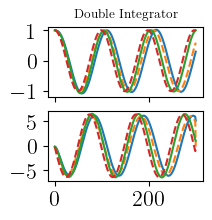

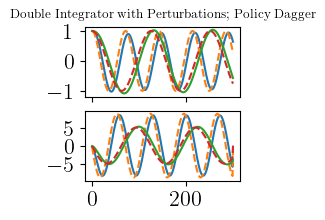

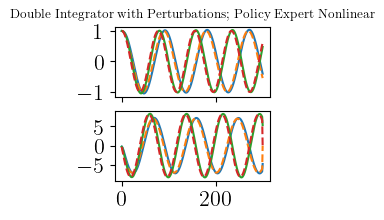

In [11]:
# Evaluate

def policy_NN(x, x_des):
    input_NN = np.concatenate([x, x_des])
    return policy.predict(input_NN)

multiple_traj_reg(system, sys_name = 'Double Integrator', policy=policy_NN)
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations; Policy Dagger', policy=policy_NN)
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations; Policy Expert Nonlinear', policy=expert_policy_nonlinear)
